# Graph convolutional network 2D toy models

In this notebook we'll test out some first graph convolutional models on simple toy data.

In [9]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib notebook

In [21]:
cuda = False

## Data utilties

In [69]:
np.random.uniform?

In [78]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n).astype(np.float32)
    xout = np.random.uniform(size=n).astype(np.float32)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def generate_data(n_events, n_tracks, det_r):
    n_det_layers = det_r.shape[0]

    # Generate all the tracks we'll need
    tracks = np.stack([gen_tracks(n_events, det_r)
                       for i in range(n_tracks)], axis=1)

    # Sort according to the first hit position, so the labels are
    # consistently defined in terms of the first layer hit order.
    # Note: singleton ('None') idx axes indicate a repeat-broadcast.
    idx0 = np.arange(n_events)[:, None, None]
    idx1 = tracks[:, :, 0].argsort(axis=1)[:, :, None]
    idx2 = np.arange(n_det_layers)[None, None, :]
    tracks = tracks[[idx0, idx1, idx2]]
    tracks.shape

    # Now sort all hits on all layers by their position.
    # This sort index relative to previous sort gives us our hit labels.
    idx = np.argsort(tracks, axis=1)
    x = tracks[[idx0, idx, idx2]]
    
    # Transpose to shape (n_event, n_layer, n_hit)
    return x.transpose([0,2,1]), idx.transpose([0,2,1])

def calc_adjacency(x, r, l, y):
    """Calculate toy data adjacency matrices"""
    # Detector layer adjacency
    adj_l = (np.abs(l[:, None, :] - l[:, :, None]) == 1).astype(np.int)
    # Hit-pair-wise slopes
    dx = x[:, None, :] - x[:, :, None]
    dr = r[:, None, :] - r[:, :, None]
    # Div-by-zero protection
    dr[dr == 0] = 1e-7
    slope = dx / dr
    # Entry and exit points for each slope
    rn = r.max()
    x0 = x[:, None, :] - slope * r[:, None, :]
    xn = x[:, None, :] + slope * (rn - r[:, None, :])
    # Adjacency from entry and exit constraints
    adj_x0 = (x0 < 1) & (x0 > 0)
    adj_xn = (xn < 1) & (xn > 0)
    # Final combined adjacency matrices
    adj = adj_l * adj_x0 * adj_xn
    # True adjacency matrix
    adj_y = (y[:, None, :] == y[:, :, None]) * adj_l
    return adj, adj_y

In [22]:
# PyTorch memory allocations and conversions
np_to_torch_cpu = lambda x: Variable(torch.from_numpy(x))
np_to_torch_gpu = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_zeros_cpu = lambda *size: Variable(torch.FloatTensor(*size).zero_())
torch_zeros_gpu = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())

np_to_torch = np_to_torch_gpu if cuda else np_to_torch_cpu
torch_zeros = torch_zeros_gpu if cuda else torch_zeros_cpu

## Generate a dataset

In [3]:
det_r = np.array([0, 1, 2, 3], dtype=np.float)
n_det_layers = det_r.shape[0]
n_events = 1024
n_tracks = 5

In [4]:
# Hit position and label
hits_x, hits_y = generate_data(n_events, n_tracks, det_r)
# Hit radius
hits_r = np.broadcast_to(det_r[None, :, None], hits_x.shape)
# Layer number
hits_l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], hits_x.shape)
print(hits_x.shape, hits_y.shape)

# Flattened arrays
x, y, r, l = [a.reshape((n_events, -1)) for a in [hits_x, hits_y, hits_r, hits_l]]
print(map(np.shape, [x, y, r, l]))

(1024, 4, 5) (1024, 4, 5)
[(1024, 20), (1024, 20), (1024, 20), (1024, 20)]


In [17]:
# Stack features together
X = np.stack([x, r, l], axis=-1)

# Adjacency matrices for all events
adj, adj_y = calc_adjacency(x, r, l, y)

<IPython.core.display.Javascript object>


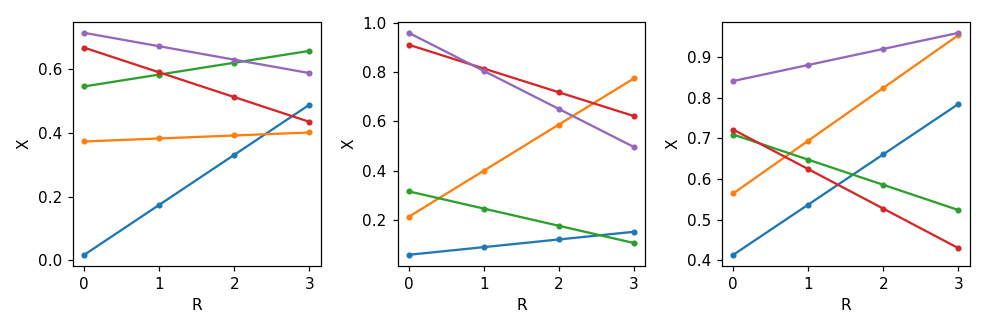

In [6]:
# As a sanity check, plot a few events
nrows, ncols = 1, 3
plt.figure(figsize=(9,3))

for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    xi, yi = x[i], y[i]
    for j in range(n_tracks):
        plt.plot(det_r, xi[yi==j], '.-')
    plt.xlabel('R')
    plt.ylabel('X')
plt.tight_layout()

<IPython.core.display.Javascript object>


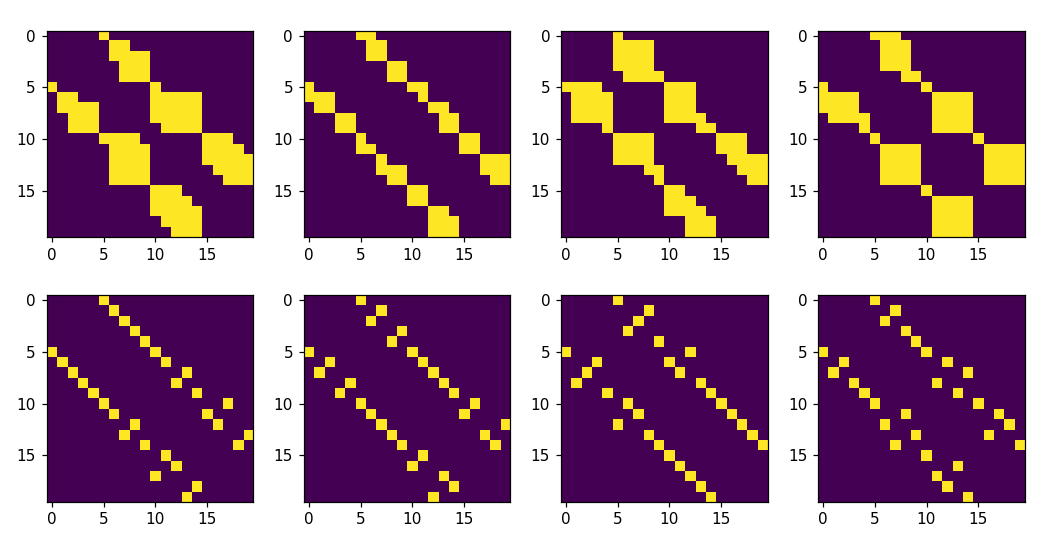

In [8]:
# Draw some adjacency matrices
plt.figure(figsize=(9.5, 5))
nrows = 4
for i in range(nrows):
    plt.subplot(2, nrows, i + 1)
    plt.imshow(adj[i])
    plt.subplot(2, nrows, i + 5)
    plt.imshow(adj_y[i])
plt.tight_layout()

## Discussion

What kind of model do I want to implement?
- single target classifier
  - binary classification of hits for one candidate track
  - randomly choose one of the tracks as the target
  - attach an input label to all hits. Mark the seed with a 1, and the rest with 0.
  - I would probably want to change the way I generated the data and avoid the first sort.
- multi-target classifier
  - specify the labels on the first layer hits, and classify all the rest
  - I could use categorical labels on the input, but that's a lot of wasted space
  - can I use floating point numbers for the input labels?
  - I could also make the network learn to sort according to the first layer hit order.
- segment classifier
  - I'm still not really sure about the best way to implement this. It comes down to how do you define operations on the dual graph using the adjacency matrix?

### Graph op development
Let's start by constructing a graph convolution module.

In [94]:
def repeat_module(module, x):
    """Applies module on last axis, repeating over others"""
    return module(x.view(-1, x.size(-1))).view(x.size()[:-1] + (-1,))

In [98]:
class GraphConv(nn.Module):
    """
    A graph convolution module.
    
    This module takes an input tensor of node features X and some form
    of adjacency matrix A and applies a linear transformation of the form
        A * X * W + b
    where W and b are weights and biases, respectively.
    """
    
    def __init__(self, input_dim, output_dim):
        super(GraphConv, self).__init__()
        # We implement the patch operator as a linear module
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x, a):
        ax = torch.matmul(a, x)
        return repeat_module(self.linear, ax)

In [99]:
# Convert some data into pytorch for development
train_X = np_to_torch(X.astype(np.float32))
train_A = np_to_torch(adj.astype(np.float32))

batch_size = 32

batch_X = train_X[:batch_size]
batch_A = train_A[:batch_size]

In [100]:
input_dim = X.shape[2]
output_dim = 16

In [101]:
gc = GraphConv(input_dim, output_dim)

In [104]:
F.relu(gc(batch_X, batch_A))

Variable containing:
(0 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.5198   0.4867   0.0000
   0.0000   0.0000   0.0000  ...    0.9213   0.1814   0.0000
   0.0000   0.0000   0.0000  ...    1.8002   0.0000   0.4535
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    5.2729   0.0000   0.2791
   0.0000   0.0000   0.0000  ...    4.1735   0.0000   0.2047
   0.0000   0.0000   0.0000  ...    3.0885   0.0000   0.0976

(1 ,.,.) = 
   0.0000   0.0000   0.0000  ...    1.0696   0.4297   0.0000
   0.0000   0.0000   0.0000  ...    0.9961   0.3066   0.0000
   0.0000   0.0000   0.0000  ...    0.9961   0.3066   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    2.0339   0.0890   0.0000
   0.0000   0.0000   0.0000  ...    3.0412   0.0000   0.2053
   0.0000   0.0000   0.0000  ...    3.0412   0.0000   0.2053

(2 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.4335   0.3422   0.0000
   0.0000   0.0000   0.000